In [15]:
from scipy.stats import moment
from numpy import mean, var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
# set configurations for number of samples and moments
s_size = 10
nr_sample = 2
nr_moments = 4

## Bounded intervals

In [17]:
# Samples from distributions with bounded intervals
from scipy.stats import arcsine, beta, powerlaw, trapezoid, triang, uniform

r_arcsine = arcsine.rvs(size=(nr_sample, s_size),random_state=10)
r_beta = beta.rvs(1,2, size=(nr_sample, s_size), random_state=10)
r_powerlaw = powerlaw.rvs(0.3, size=(nr_sample, s_size),random_state=10)
r_trapezoid = trapezoid.rvs(0.3, 0.8, size=(nr_sample, s_size), random_state=10)
r_traing = triang.rvs(0.3, size=(nr_sample, s_size),random_state=10)
r_uniform = uniform.rvs(size=(nr_sample, s_size),random_state=10)

bounded_c_rvs = [r_arcsine, r_beta, r_powerlaw, r_trapezoid, r_traing, r_uniform]
bounded_c_dists_names = ['arcsine', 'beta', 'powerlaw', 'trapezoid', 'triangular', 'uniform']

bounded_c = pd.DataFrame()

# parameter moment is the central mean, so I used mean() for n=1
for i in range(len(bounded_c_rvs)):
    m = np.zeros((nr_moments,nr_sample))
    m[0,]  = mean(bounded_c_rvs[i], axis = 1)
    for n in range(2,nr_moments+1):
        m[n-1,] = moment(bounded_c_rvs[i], n, axis=1)
        
    df_temp = pd.DataFrame(np.transpose(m))
    df_temp['dist'] = bounded_c_dists_names[i]

    bounded_c=pd.concat([bounded_c, df_temp], ignore_index=True)
    

In [18]:
def generate_moments_df(r, ms, s):
    df = pd.DataFrame()
    for i in range(len(r)):
        m = np.zeros((ms,s))
        m[0,]  = mean(r[i], axis = 1)
        for n in range(2,ms+1):
            m[n-1,] = moment(r[i], n, axis=1)

        df_temp = pd.DataFrame(np.transpose(m))
        df_temp['dist'] = bounded_c_dists_names[i]

        df=pd.concat([df, df_temp], ignore_index=True)
    return df

In [19]:
generate_moments_df(bounded_c_rvs, 5, nr_sample)

,0,1,2,3,4,dist
0,0.409759,0.133492,0.008527,0.021801,0.003055,arcsine
1,0.668998,0.101442,-0.032035,0.027668,-0.014994,arcsine
2,0.305954,0.040414,0.000272,0.002902,0.000104,beta
3,0.314615,0.070845,0.014492,0.012941,0.005379,beta
4,0.153481,0.030561,0.002921,0.001419,0.000253,powerlaw
5,0.337140,0.075661,0.012620,0.012758,0.004036,powerlaw
6,0.449863,0.051348,-0.000562,0.003829,-0.000224,trapezoid
7,0.608003,0.055204,-0.015707,0.011510,-0.005645,trapezoid
8,0.364264,0.033898,0.000006,0.001717,-0.000048,triangular
9,0.508485,0.046109,-0.006861,0.006627,-0.002044,triangular


NameError: name 'rvs' is not defined

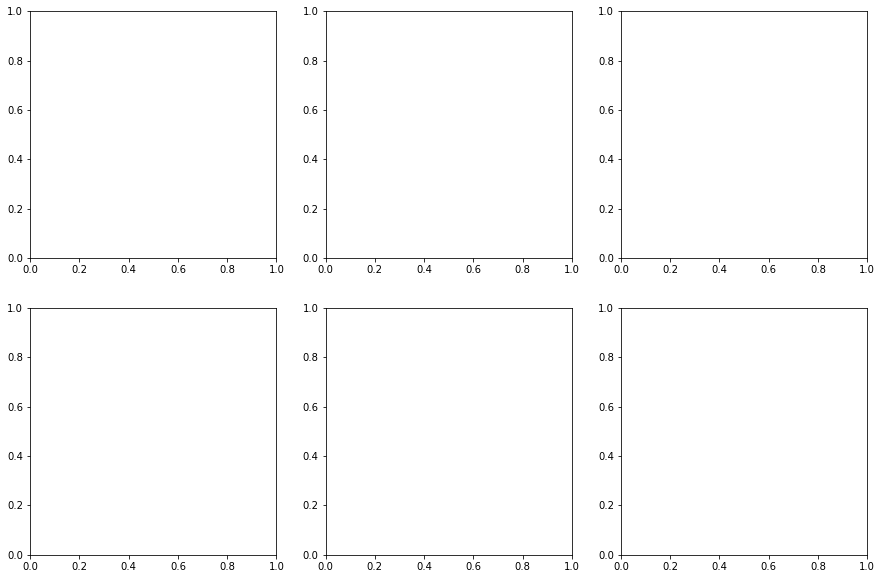

In [20]:
# plotting
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize =(15,10))

for row in range(nrow):
    for col in range(ncol):
        for i in range(nr_sample):
            ax[row,col].hist(rvs[row*3+col][i,:], density=True, bins='auto', histtype='stepfilled', alpha=0.1)
            ax[row,col].set_title(dists_names[row*3+col])
            ax[row,col].set_xlim(0,1)
            ax[row,col].set_ylim(0,10)

In [21]:
# predictors
X = bounded_c.drop('dist', axis=1)

# Scaling data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# response variable
y = bounded_c['dist']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.2, random_state=10)

### SVM

In [22]:
# find the best parameters
param_grid = [
    {'C':np.logspace(0.1, 50, 20),
     'gamma':np.logspace(0.001, 10, 20), 
     'kernel':['rbf']},
]

optimal_params = GridSearchCV(SVC(), param_grid,cv=5, verbose=0)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

c = optimal_params.best_params_['C']
g = optimal_params.best_params_['gamma']

clf_svm = SVC(random_state=10, C=c, gamma=g)
clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(c_matrix, display_labels=clf_svm.classes_)
disp.plot(cmap=plt.cm.Blues, colorbar=False, xticks_rotation='vertical')
plt.show()

scores = cross_val_score(clf_svm, X, y, cv=5)
scores

ValueError: n_splits=5 cannot be greater than the number of members in each class.

### Gradient Boosting

In [24]:
param_grid = [
    {'n_estimators':[100, 500, 750],
     'learning_rate':[0.001, 0.01, 0.1], 
     'max_depth':[3, 5, 8]},
]

optimal_params = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10, verbose=0)

optimal_params.fit(X_train, y_train)
print(optimal_params.best_params_)

n_estimators = optimal_params.best_params_['n_estimators']
l_rate = optimal_params.best_params_['learning_rate']
m_depth = optimal_params.best_params_['max_depth']

clf_gbm = GradientBoostingClassifier(n_estimators=n_estimators,
                                     learning_rate=l_rate,
                                     max_depth=m_depth)
                                     
clf_gbm.fit(X_train, y_train)

y_pred = clf_gbm.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(c_matrix, display_labels=clf_gbm.classes_)
disp.plot(cmap=plt.cm.Blues, colorbar=False, xticks_rotation='vertical')
plt.show()

scores = cross_val_score(clf_gbm, X, y, cv=5)
scores

KeyboardInterrupt: 

In [63]:
# Samples from different distributions
# exponential
ex_lambda = 3.5
r_expon = expon.rvs(size=(nr_sample,s_size), scale = 1/ex_lambda, random_state=10)

# gamma
alpha = 1
r_gamma = gamma.rvs(alpha, size=(nr_sample, s_size), random_state=10)

# chi
d_f = 25
r_chi = chi.rvs(d_f, size=(nr_sample, s_size), random_state=10)

# lognormal
s = 1
r_lognorm = lognorm.rvs(s, size=(nr_sample, s_size), random_state=10)

# beta
a, b = 0.5, 0.5
r_beta = beta.rvs(a, b, size=(nr_sample, s_size), random_state=10)

# trapezoind
c, d = 0.3, 0.4
r_trapezoid = trapezoid.rvs(c, d, size=(nr_sample, s_size), random_state=10)

# exponpow
b = 5
r_exponpow = exponpow.rvs(b, size=(nr_sample, s_size), random_state=10)

# normal
r_norm = norm.rvs(size=(nr_sample, s_size), random_state=10)

# cosine
r_cosine = cosine.rvs(size=(nr_sample, s_size), random_state=10)

# cauchy
r_cauchy = cauchy.rvs(size=(nr_sample, s_size), random_state=10)

# poisson
mu = 10
r_pois = poisson.rvs(mu, size=(nr_sample, s_size), random_state=10)

# hypergeom
M, n, N = 20, 7, 12
r_hypergeom =  hypergeom.rvs(M, n, N, size=(nr_sample, s_size))

In [60]:
rvs = [r_expon, r_gamma, r_lognorm, r_beta, r_trapezoid, r_norm, r_hypergeom, r_exponpow, r_pois]
dists_names = ['exponential', 'gamma', 'lognormal','beta', 'trapezoid', 'normal','hyper_geometric',
               'exponential_power','poisson']

df_final = pd.DataFrame()

# parameter moment is the central mean, so I used mean() for n=1
for i in range(len(rvs)):
    m = np.zeros((nr_moments,nr_sample))
    m[0,]  = mean(rvs[i], axis = 1)
    for n in range(2,nr_moments+1):
        m[n-1,] = moment(rvs[i], n, axis=1)
        
    df_temp = pd.DataFrame(np.transpose(m))
    df_temp['dist'] = dists_names[i]

    df_final=pd.concat([df_final, df_temp], ignore_index=True)
    
# write to csv
df_final.to_csv('moments.csv', index=False) 


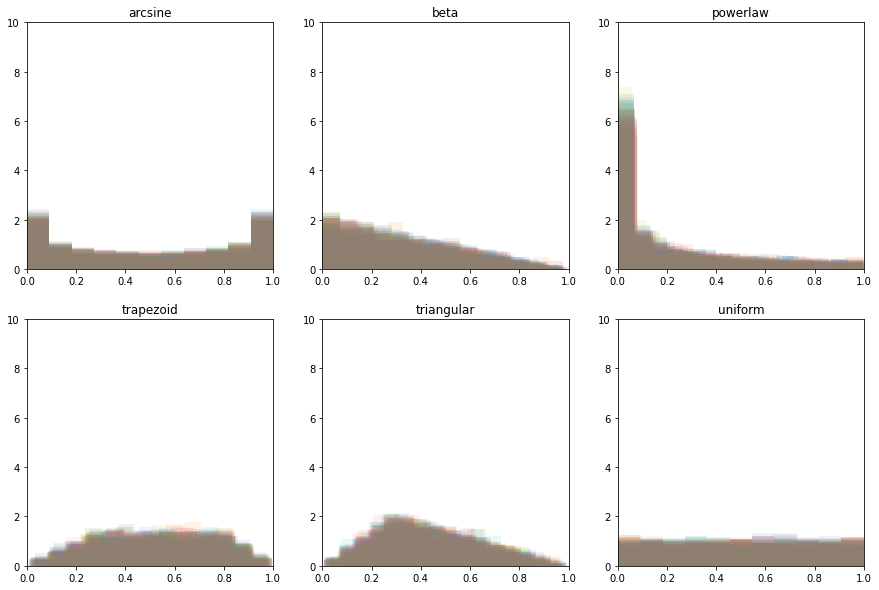

In [61]:
# plotting
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize =(15,10))

for row in range(nrow):
    for col in range(ncol):
        for i in range(nr_sample):
            ax[row,col].hist(rvs[row*3+col][i,:], density=True, bins='auto', histtype='stepfilled', alpha=0.1)
            ax[row,col].set_title(dists_names[row*3+col])
            ax[row,col].set_xlim(0,1)
            ax[row,col].set_ylim(0,10)

In [286]:
df_final.head()

,0,1,2,3,4,dist
0,0.472515,0.215198,0.214862,0.489494,1.208886,exponential
1,0.501796,0.249386,0.232755,0.492877,1.031487,exponential
2,0.467825,0.222402,0.231120,0.568067,1.641068,exponential
3,0.525629,0.245039,0.205732,0.395267,0.715290,exponential
4,0.499297,0.248144,0.230677,0.460638,0.888709,exponential


In [23]:
pd.set_option('display.max_rows', None)
df_final

,0,1,2,3,4,dist
0,0.278477,0.076947,0.039534,0.044959,0.050045,exponential
1,0.294094,0.090901,0.069032,0.132611,0.306223,exponential
2,0.273634,0.081426,0.043785,0.048736,0.053657,exponential
3,0.277206,0.074974,0.037583,0.041791,0.046933,exponential
4,0.265108,0.070054,0.036772,0.040880,0.045851,exponential
5,0.287305,0.086687,0.052420,0.071863,0.110257,exponential
6,0.270158,0.083211,0.061479,0.098035,0.175570,exponential
7,0.271438,0.074232,0.041453,0.052457,0.070142,exponential
8,0.279658,0.087117,0.066054,0.102184,0.170926,exponential
9,0.297224,0.087612,0.055138,0.075090,0.105865,exponential


In [25]:
df_final.var(numeric_only=True)

0    9.263621e+00
1    9.846756e+00
2    2.238705e+02
3    1.241443e+05
4    1.052515e+08
dtype: float64